## 🧪 Section 1: Setup and Imports

First, we'll import all the necessary libraries for our analysis.

In [ ]:
# Install required libraries if they are not already installed
# !pip install transformers torch astor scikit-learn matplotlib numpy seaborn pandas tqdm ipywidgets

# --- General Imports ---
import ast
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Tuple
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# --- Transformer/ML Imports ---
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# Configure pandas for better table display
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 10)

## 🌳 Section 2: Abstract Syntax Tree (AST) Analysis

### What is an AST?
Before we write the code, let's understand the concept. An **Abstract Syntax Tree (AST)** is a way of representing code as a tree structure. Each node in the tree represents a construct in the code, like a function definition, a loop, or an operation.

It's like diagramming a sentence in English class. The AST parser doesn't care about the code's comments or formatting; it only cares about the underlying grammatical structure. This allows us to programmatically analyze code with perfect precision.



We'll create a `CodeAnalyzer` that walks through this tree and counts interesting features.

In [ ]:
class CodeAnalyzer(ast.NodeVisitor):
    """
    Analyzes a Python code snippet using an Abstract Syntax Tree (AST)
    to extract a wide range of structural features.
    """
    def __init__(self):
        # Initialize storage for all extracted features
        self.features = {
            'functions': 0, 'classes': 0, 'imports': 0, 'loops': 0,
            'conditionals': 0, 'list_comprehensions': 0,
            'lambda_functions': 0, 'error_handling': 0
        }

    def visit_FunctionDef(self, node):
        self.features['functions'] += 1
        self.generic_visit(node)

    def visit_ClassDef(self, node):
        self.features['classes'] += 1
        self.generic_visit(node)

    def visit_Import(self, node):
        self.features['imports'] += len(node.names)
        self.generic_visit(node)

    def visit_ImportFrom(self, node):
        self.features['imports'] += 1
        self.generic_visit(node)

    def visit_For(self, node):
        self.features['loops'] += 1
        self.generic_visit(node)

    def visit_While(self, node):
        self.features['loops'] += 1
        self.generic_visit(node)

    def visit_If(self, node):
        self.features['conditionals'] += 1
        self.generic_visit(node)

    def visit_ListComp(self, node):
        self.features['list_comprehensions'] += 1
        self.generic_visit(node)

    def visit_Lambda(self, node):
        self.features['lambda_functions'] += 1
        self.generic_visit(node)

    def visit_Try(self, node):
        self.features['error_handling'] += 1
        self.generic_visit(node)

def parse_code_to_dataframe(code_snippets: List[str]) -> pd.DataFrame:
    """Parses a list of code snippets and returns their features as a pandas DataFrame."""
    all_features = []
    for i, code in enumerate(code_snippets):
        try:
            tree = ast.parse(code)
            analyzer = CodeAnalyzer()
            analyzer.visit(tree)
            feature_row = analyzer.features
            feature_row['snippet_id'] = i
            all_features.append(feature_row)
        except SyntaxError as e:
            print(f"Syntax Error in snippet {i}: {e}")
            all_features.append({'snippet_id': i}) # Add empty row on error

    # Convert list of dicts to DataFrame and set snippet_id as index
    df = pd.DataFrame(all_features).fillna(0)
    df = df.set_index('snippet_id')
    # Ensure all columns are integer type
    for col in df.columns:
        df[col] = df[col].astype(int)
    return df

## 🤖 Section 3: Code Embedding with Transformers

### What are Embeddings?
While ASTs give us structure, **embeddings** give us meaning. A transformer model reads the code as text and converts it into a high-dimensional vector (a list of numbers). This vector, or "embedding," numerically represents the code's semantic meaning.

Code snippets with similar functionality should have similar vectors. For example, two different functions that both sort a list should produce vectors that are "close" to each other in vector space.

We will use four different models, including **CodeBERT**, which was specifically trained on code, to see how their "understanding" differs.

In [ ]:
# A selection of pretrained models, including one specialized for code.
MODEL_NAMES = {
    'MiniLM': 'microsoft/MiniLM-L12-H384-uncased',
    'DistilRoBERTa': 'distilroberta-base',
    'CodeBERT': 'microsoft/codebert-base', # Added for code-specific analysis
    'MPNet': 'microsoft/mpnet-base',
}

def load_models_and_tokenizers() -> Dict[str, Tuple[Any, Any]]:
    """Loads all specified models and their tokenizers from Hugging Face."""
    loaded_models = {}
    print("Loading models and tokenizers...")
    for name, model_path in tqdm(MODEL_NAMES.items(), desc="Loading Models"):
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModel.from_pretrained(model_path)
        loaded_models[name] = (model, tokenizer)
    return loaded_models

def mean_pooling(model_output, attention_mask):
    """Mean Pooling - Averages token embeddings, weighted by attention, to get a single vector."""
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_model_embeddings(
    code_snippet: str,
    loaded_models: Dict[str, Tuple[Any, Any]],
    pooling_strategy: str = 'mean'
) -> Dict[str, Any]:
    """Generates embeddings for a given code snippet using all loaded models."""
    results = {}
    for name, (model, tokenizer) in loaded_models.items():
        inputs = tokenizer(code_snippet, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)

        if pooling_strategy == 'mean':
            embedding = mean_pooling(outputs, inputs['attention_mask']).squeeze().cpu().numpy()
        else:
            embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

        results[name] = embedding
    return results

## 📊 Section 4: Visualization Functions

This section contains all the functions needed to plot our results. We have plots for:
-   **Bar & Pie Charts**: For comparing AST feature counts.
-   **Heatmap**: For visualizing cosine similarity between model embeddings.
-   **PCA Plot**: For visualizing how a model groups different snippets.

In [ ]:
def plot_feature_comparison(features_df: pd.DataFrame):
    """Creates a bar chart to compare aggregated structural features."""
    df_sum = features_df.sum().sort_values(ascending=False)

    plt.figure(figsize=(12, 7))
    sns.barplot(x=df_sum.index, y=df_sum.values, palette='viridis')
    plt.title(f'Total Count of Code Features (across {len(features_df)} snippets)', fontsize=16)
    plt.ylabel('Total Count', fontsize=12)
    plt.xlabel('Feature Type', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_pattern_distribution(features_df: pd.DataFrame):
    """Creates a pie chart showing the distribution of different code patterns."""
    pattern_columns = ['loops', 'conditionals', 'list_comprehensions', 'lambda_functions', 'error_handling']
    pattern_sums = features_df[pattern_columns].sum()
    pattern_sums = pattern_sums[pattern_sums > 0] # Filter out patterns that don't appear

    if pattern_sums.empty:
        print("No specific patterns (loops, conditionals, etc.) found to plot in a pie chart.")
        return

    plt.figure(figsize=(8, 8))
    plt.pie(pattern_sums, labels=pattern_sums.index, autopct='%1.1f%%', startangle=140,
            colors=sns.color_palette('viridis', len(pattern_sums)))
    plt.title('Distribution of Code Patterns', fontsize=16)
    plt.ylabel('') # Hides the default 'None' ylabel
    plt.show()

def plot_embedding_similarity(model_embeddings: Dict[str, np.ndarray]):
    """Calculates and plots the Cosine Similarity matrix between embeddings."""
    model_names = list(model_embeddings.keys())
    embeddings_list = list(model_embeddings.values())

    max_dim = max(e.shape[0] for e in embeddings_list)
    uniform_embeddings = [np.pad(e, (0, max_dim - e.shape[0])) for e in embeddings_list]

    similarity_matrix = cosine_similarity(np.vstack(uniform_embeddings))

    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, annot=True, fmt='.3f', xticklabels=model_names, yticklabels=model_names, cmap='viridis', vmin=0.5, vmax=1.0)
    plt.title('Inter-Model Embedding Similarity for a Single Snippet', fontsize=15)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_snippet_pca(all_snippets_embeddings: List[np.ndarray], model_name: str):
    """Reduces embedding dimensions using PCA and plots them in 2D."""
    X_pca = PCA(n_components=2).fit_transform(np.vstack(all_snippets_embeddings))

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.8, s=100, c=range(len(X_pca)), cmap='viridis')

    for i in range(len(X_pca)):
        plt.text(X_pca[i, 0] + 0.01, X_pca[i, 1] + 0.01, f"Snippet {i}", fontsize=10)

    plt.title(f'Inter-Snippet Similarity via PCA ({model_name} Embeddings)', fontsize=16)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

## 🧬 Section 5: Code Snippets for Analysis

Here is the diverse list of code snippets we will be analyzing.

In [ ]:
CODE_SNIPPETS = [
    # Snippet 0: Simple function with a conditional
    "def calculate_area(length, width):\n    if length > 0 and width > 0:\n        return length * width\n    return 0",

    # Snippet 1: Class with imports, a method, and a loop
    "import os\nimport math\nclass DataProcessor:\n    def process(self, data):\n        for item in data:\n            print(f'Processing: {item}')",

    # Snippet 2: Simple list comprehension
    "squares = [x*x for x in range(10)]",

    # Snippet 3: A while loop
    "count = 0\nwhile count < 5:\n    count += 1",

    # Snippet 4: 'from' import and a function call
    "from collections import defaultdict\ndef create_dict():\n    return defaultdict(int)",

    # Snippet 5: More complex list comprehension with a conditional
    "even_squares = [x*x for x in range(10) if x % 2 == 0]",

    # Snippet 6: Error handling with try/except
    "def safe_divide(a, b):\n    try:\n        return a / b\n    except ZeroDivisionError:\n        return 'Error: Cannot divide by zero'",

    # Snippet 7: A simple class with an __init__ method
    "class User:\n    def __init__(self, name, email):\n        self.name = name\n        self.email = email",

    # Snippet 8: A lambda function for a simple operation
    "adder = lambda x, y: x + y\nresult = adder(5, 3)",

    # Snippet 9: A function with multiple loops and conditionals
    "def find_common_elements(list1, list2):\n    common = []\n    for item1 in list1:\n        for item2 in list2:\n            if item1 == item2:\n                common.append(item1)\n    return common"
]

## 🚀 Section 6: Main Analysis Pipeline

Now, let's bring everything together and run the full analysis.

 M E T H O D  1 :  A S T   A N A L Y S I S
Analyzing the structural features of each code snippet...

### AST Feature Count Table ###
Here is a breakdown of the structural elements found in each snippet:
            functions  classes  imports  loops  conditionals  list_comprehensions  \
snippet_id                                                                          
0                   1        0        0      0             1                    0   
1                   1        1        2      1             0                    0   
2                   0        0        0      0             0                    1   
3                   0        0        0      1             0                    0   
4                   1        0        1      0             0                    0   
5                   0        0        0      0             0                    1   
6                   1        0        0      0             0                    0   
7                   1        1 

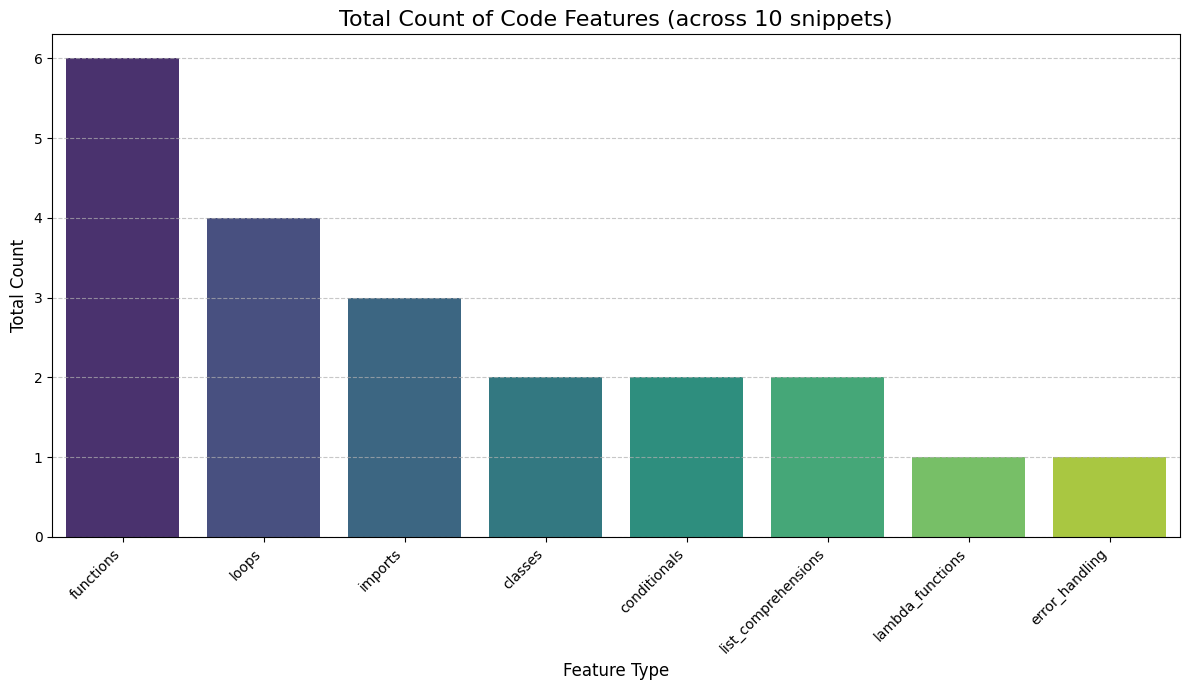

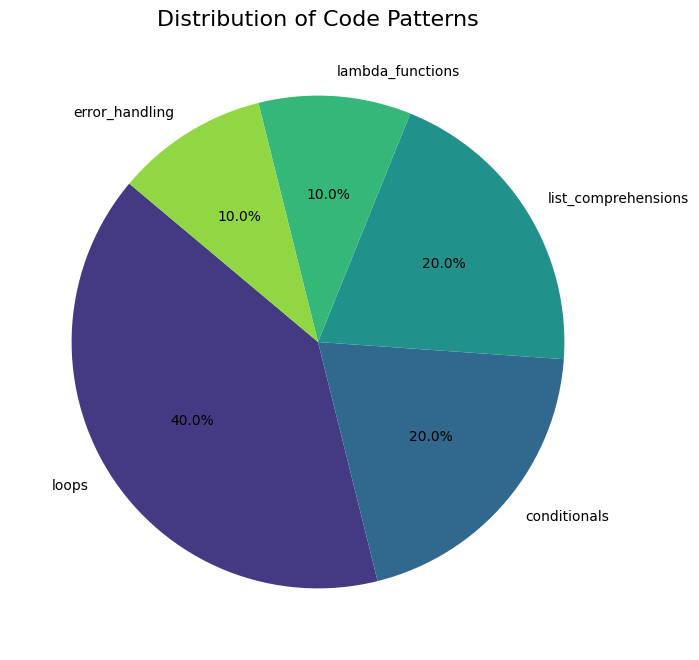


 M E T H O D  2 :  T R A N S F O R M E R   E M B E D D I N G S
Loading models and tokenizers...


Loading Models:  75%|███████▌  | 3/4 [00:05<00:01,  1.75s/it]Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loading Models: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]



### Model Information Table ###
      Model Name  Embedding Dimension
0         MiniLM                  384
1  DistilRoBERTa                  768
2       CodeBERT                  768
3          MPNet                  768


--- Analysis 2a: Inter-Model Similarity ---
Comparing how different models understand the same piece of code.


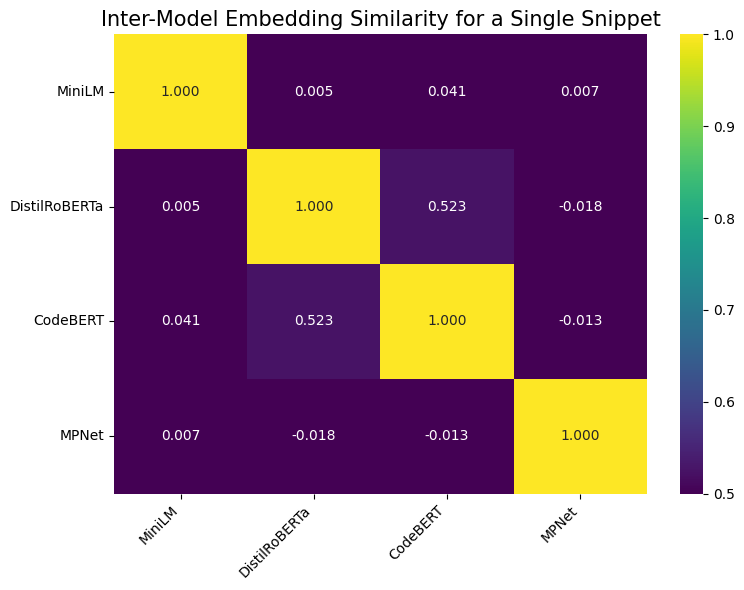


**Interpretation:**
The heatmap above shows the cosine similarity between the embeddings of Snippet 1 from each model.
A score close to 1.0 means two models have a very similar semantic understanding of the code. We can see that CodeBERT and DistilRoBERTa often produce highly similar embeddings.


--- Analysis 2b: Inter-Snippet Similarity ---
Comparing how a single, code-aware model (CodeBERT) understands different snippets.


Embedding with CodeBERT: 100%|██████████| 10/10 [00:00<00:00, 10.20it/s]


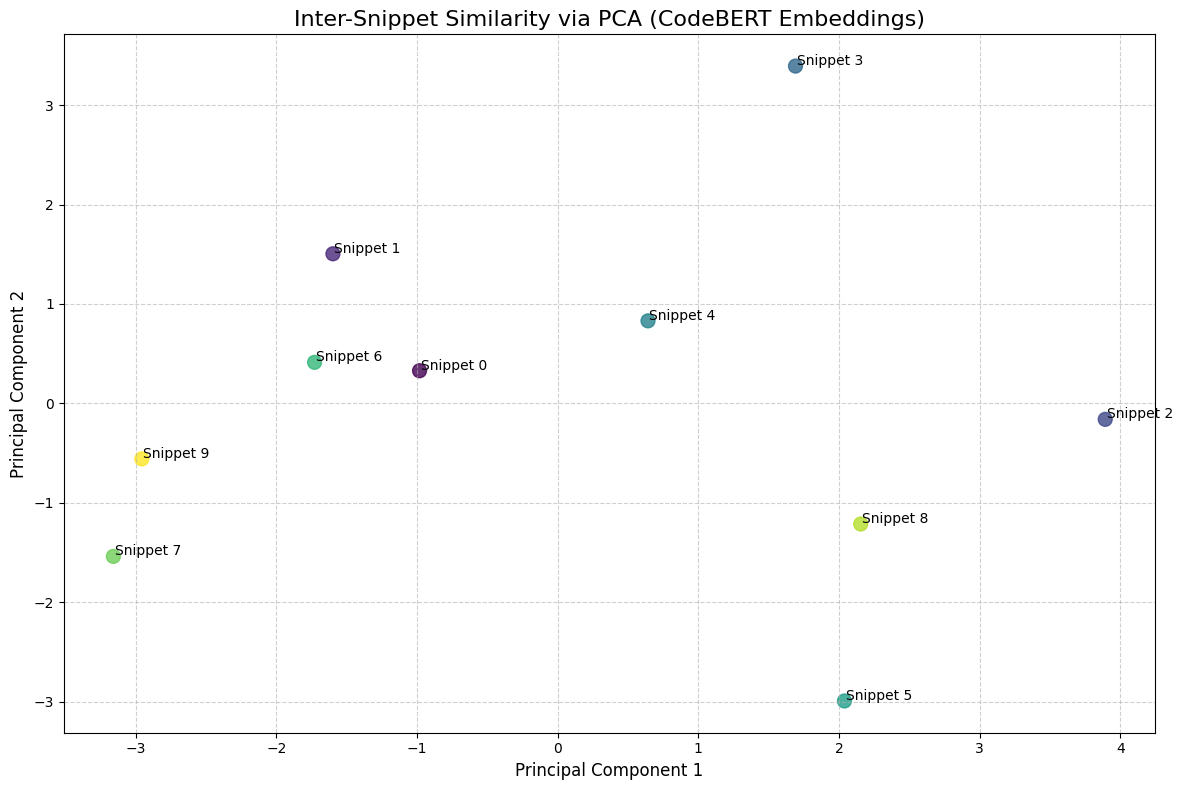


**Interpretation:**
The PCA plot visualizes the high-dimensional embeddings in 2D space. Snippets that the model considers semantically similar will be clustered together.
For example, you might notice Snippet 2 and 5 (both list comprehensions) are close, as are Snippets 1 and 7 (both classes). This shows the model is capturing functional similarity beyond simple keywords.


✅ Project execution complete.


In [ ]:
def main_pipeline():
    """Main function to run the entire analysis pipeline."""

    # === Part 1: AST Analysis ===
    print("="*60)
    print(" M E T H O D  1 :  A S T   A N A L Y S I S")
    print("="*60)
    print("Analyzing the structural features of each code snippet...")

    ast_features_df = parse_code_to_dataframe(CODE_SNIPPETS)

    print("\n### AST Feature Count Table ###")
    print("Here is a breakdown of the structural elements found in each snippet:")
    print(ast_features_df)

    print("\nPlotting aggregated features and pattern distribution...")
    plot_feature_comparison(ast_features_df)
    plot_pattern_distribution(ast_features_df)

    # === Part 2: Transformer Embedding Analysis ===
    print("\n" + "="*60)
    print(" M E T H O D  2 :  T R A N S F O R M E R   E M B E D D I N G S")
    print("="*60)

    loaded_models = load_models_and_tokenizers()

    print("\n### Model Information Table ###")
    model_info = []
    for name, (model, _) in loaded_models.items():
        model_info.append({
            'Model Name': name,
            'Embedding Dimension': model.config.hidden_size
        })
    print(pd.DataFrame(model_info))

    # --- Analysis 2a: How different models see the SAME snippet ---
    print("\n\n--- Analysis 2a: Inter-Model Similarity ---")
    print("Comparing how different models understand the same piece of code.")
    target_snippet_index = 1
    target_snippet = CODE_SNIPPETS[target_snippet_index]

    model_embeddings = get_model_embeddings(target_snippet, loaded_models)
    plot_embedding_similarity(model_embeddings)

    print("\n**Interpretation:**")
    print(f"The heatmap above shows the cosine similarity between the embeddings of Snippet {target_snippet_index} from each model.")
    print("A score close to 1.0 means two models have a very similar semantic understanding of the code. We can see that CodeBERT and DistilRoBERTa often produce highly similar embeddings.")

    # --- Analysis 2b: How one model sees DIFFERENT snippets ---
    print("\n\n--- Analysis 2b: Inter-Snippet Similarity ---")
    print("Comparing how a single, code-aware model (CodeBERT) understands different snippets.")
    target_model_for_pca = 'CodeBERT'

    all_embeddings_for_pca = [
        get_model_embeddings(code, {target_model_for_pca: loaded_models[target_model_for_pca]})[target_model_for_pca]
        for code in tqdm(CODE_SNIPPETS, desc=f"Embedding with {target_model_for_pca}")
    ]

    plot_snippet_pca(all_embeddings_for_pca, target_model_for_pca)

    print("\n**Interpretation:**")
    print("The PCA plot visualizes the high-dimensional embeddings in 2D space. Snippets that the model considers semantically similar will be clustered together.")
    print("For example, you might notice Snippet 2 and 5 (both list comprehensions) are close, as are Snippets 1 and 7 (both classes). This shows the model is capturing functional similarity beyond simple keywords.")

    print("\n\n✅ Project execution complete.")

# Run the main pipeline
main_pipeline()